# Multi-pedestrian Dataset Tutorial

Author: [Zhe Huang](https://github.com/tedhuang96) <br/>
Date: Nov. 8, 2020 <br/>
The code base is heavily borrowed from [Social-STGCNN](https://github.com/abduallahmohamed/Social-STGCNN).

## 1. Set up source files, packages and arguments.

In [ ]:
# Clone source files into Colab.
!git clone https://github.com/tedhuang96/torch_data_tutorial.git

In [45]:
# Import packages and check GPU.
# 
### expected output: ###
### cuda:0 ### or ### cpu ###

import torch
import argparse
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from os import listdir
from os.path import join
from IPython.display import HTML
from matplotlib import animation, rc
from IPython.display import HTML

from torch_data_tutorial.utils import anorm, create_datasets
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [46]:
# Write arguments.
# 
### expected output: ###
### Namespace(attn_mech='auth', dataset='zara1', obs_seq_len=8, pred_seq_len=12) ###

def arg_parse_notebook(obs_seq_len, pred_seq_len, dataset, attn_mech):
    obs_seq_len, pred_seq_len = str(obs_seq_len), str(pred_seq_len)
    parser = argparse.ArgumentParser()
    parser.add_argument('--obs_seq_len', type=int, default=0)
    parser.add_argument('--pred_seq_len', type=int, default=0)
    parser.add_argument('--dataset', default='eth',
                        help='eth,hotel,univ,zara1,zara2')
    parser.add_argument('--attn_mech', default='glob_kip',
                        help='attention mechanism: glob_kip, auth')
    args_list = ['--obs_seq_len', obs_seq_len, '--pred_seq_len', pred_seq_len, '--dataset', dataset, '--attn_mech', attn_mech]
    return parser.parse_args(args_list)

obs_seq_len, pred_seq_len, dataset, attn_mech = 8, 12, 'zara1', 'auth'
args = arg_parse_notebook(obs_seq_len, pred_seq_len, dataset, attn_mech)
print(args)

Namespace(attn_mech='auth', dataset='zara1', obs_seq_len=8, pred_seq_len=12)


## 2. Introduce multi-pedestrian datasets.

Below are snapshots from ETH/UCY datasets. These datasets provide a [benchmark](http://trajnet.stanford.edu/) for multi-pedestrian trajectory prediction algorithms which are focused on pedestrian interaction mechanism. ETH contains two scenarios and UCY contains other three. They recorded and annotated pedestrian trajectories from a bird's eye view. The annotations include frame_id, pedestrian_id, x, y. 
![title](multi_pedestrian_scenarios.png)

In [47]:
# Load an example dataset into pandas.
# 
### expected output: ###
### filename:  torch_data_tutorial/datasets/zara1/train/train.txt ###
### data table: <traj_data_table> ###
pkg_path = 'torch_data_tutorial'
traj_data_folder = join(pkg_path, 'datasets', args.dataset, 'train') # may change 'datasets' to 'datasets_loo' for the leave-one-out setting.
traj_data_filepath = join(traj_data_folder, listdir(traj_data_folder)[0])
traj_data_table = pd.read_csv(traj_data_filepath, sep="\t", header=None)
traj_data_table.columns = ["frame_id", "ped_id", "x", "y"]
print('filename: ', traj_data_filepath)
print('data table: ')
print(traj_data_table)

filename:  torch_data_tutorial/datasets/zara1/train/train.txt
data table: 
      frame_id  ped_id          x         y
0          0.0     1.0  13.448721  3.937887
1          0.0     2.0  13.343488  4.439072
2          0.0     3.0  11.912325  4.439072
3          0.0     4.0  11.828139  5.155052
4          0.0     5.0   8.713256  4.415206
...        ...     ...        ...       ...
4302    7100.0   121.0  14.475580  3.583716
4303    7100.0   122.0   6.464436  4.193730
4304    7100.0   123.0   6.411188  5.311135
4305    7100.0   124.0   5.046532  4.710906
4306    7100.0   125.0   5.027801  3.962946

[4307 rows x 4 columns]


     frame_id  ped_id          x         y
0         0.0     1.0  13.448721  3.937887
8        10.0     1.0  12.935186  3.937887
16       20.0     1.0  12.421651  3.937887
25       30.0     1.0  11.919271  3.957695
34       40.0     1.0  11.428255  3.997552
43       50.0     1.0  10.937240  4.037408
52       60.0     1.0  10.467482  3.991824
61       70.0     1.0  10.019402  3.860800
70       80.0     1.0   9.571322  3.730014
79       90.0     1.0   9.093566  3.594933
88      100.0     1.0   8.571402  3.453407
97      110.0     1.0   8.049028  3.312121
106     120.0     1.0   7.519287  3.236227
116     130.0     1.0   6.985968  3.188495
126     140.0     1.0   6.452860  3.140763
136     150.0     1.0   5.909860  3.109737
146     160.0     1.0   5.362651  3.085871
156     170.0     1.0   4.815442  3.062005
166     180.0     1.0   4.303380  2.985157
175     190.0     1.0   3.806472  2.885874
184     200.0     1.0   3.309564  2.786353
194     210.0     1.0   2.816444  2.690412
204     220

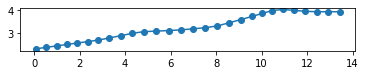

In [48]:
# Plot a pedestrian's trajectory.
# 
### expected output: ###
### <ped_traj> ###
### A trajectory plot corresponding to the pedestrian we queried. ###

ped_traj = traj_data_table.loc[traj_data_table['ped_id'] == 1]
print(ped_traj)
_, ax = plt.subplots()
ax.plot(ped_traj['x'], ped_traj['y'], 'o-')
ax.set_aspect('equal', adjustable='box')
plt.show()

   frame_id  ped_id          x         y
0       0.0     1.0  13.448721  3.937887
1       0.0     2.0  13.343488  4.439072
2       0.0     3.0  11.912325  4.439072
3       0.0     4.0  11.828139  5.155052
4       0.0     5.0   8.713256  4.415206
5       0.0     6.0   8.123953  3.460567
6       0.0     7.0   6.313953  3.842423
7       0.0     8.0   4.335581  7.350722


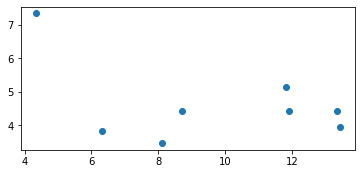

In [49]:
# Plot pedestrian positions in a frame.
# 
### expected output: ###
### <frame_pos> ###
### A scatter plot with each point representing a pedestrian position in that specific frame. ###

frame_pos = traj_data_table.loc[traj_data_table['frame_id']==0]
print(frame_pos)
_, ax = plt.subplots()
ax.plot(frame_pos['x'], frame_pos['y'], 'o')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [50]:
# Animation of pedestrian motions in a 20-frame period.
# 
### expected output: ###
### A scatter plot animation with each point representing a pedestrian position. ###
### blue means the motion is during observation period, and ren means the motion is during prediction period. ###

fig, ax = plt.subplots()
ax.set_xlim((0, 16))
ax.set_ylim((2, 9))
ped_pos, = ax.plot([], [],'o')
plt.close()

def init():
    ped_pos.set_data([], [])
    return (ped_pos,)

def animate(i):
    frame_pos = traj_data_table.loc[traj_data_table['frame_id'] == i*10]
    x, y = frame_pos['x'], frame_pos['y']
    ped_pos.set_data(x, y)
    if i > 8:
        ped_pos.set_color('C3') # red
    return (ped_pos,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=20, interval=200, blit=True)
HTML(anim.to_html5_video())

ped_ids shown up in all 20 frames: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0]


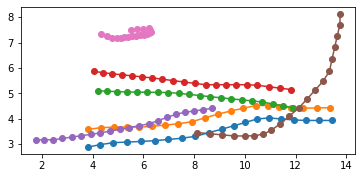

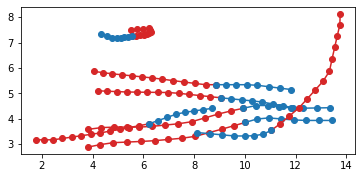

In [51]:
# We are interested in predicting pedestrian motion in the later 12 time steps
# given the observation in the first 8 time steps.
#
# We filter out common pedestrians across all 20 time steps,
# and their trajectories in these 20 time steps formed a data sample.
# 
### expected output: ###
### ped_ids shown up in all 20 frames: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0] ###
### Two trajectory plots ###

ped_ids_20_frames = []
for i in range(0, 19):
    ped_ids_20_frames.append(set(traj_data_table.loc[traj_data_table['frame_id'] == i*10]['ped_id']))
common_ped_ids_20_frames = list(set.intersection(*ped_ids_20_frames))
print('ped_ids shown up in all 20 frames:', common_ped_ids_20_frames)


_, ax = plt.subplots()
for common_ped_id in common_ped_ids_20_frames[:8]: 
    ped_traj_pred = traj_data_table.loc[(traj_data_table['ped_id'] == common_ped_id) & (traj_data_table['frame_id'] <= 190)]
    ax.plot(ped_traj_pred['x'], ped_traj_pred['y'], 'o-')
ax.set_aspect('equal', adjustable='box')
plt.show()


_, ax = plt.subplots()
for common_ped_id in common_ped_ids_20_frames[:8]: 
    ped_traj_pred = traj_data_table.loc[(traj_data_table['ped_id'] == common_ped_id) & (traj_data_table['frame_id'] >= 70) \
                                       & (traj_data_table['frame_id'] <= 190)]
    ax.plot(ped_traj_pred['x'], ped_traj_pred['y'], 'o-', c='C3') # red
    ped_traj_obs = traj_data_table.loc[(traj_data_table['ped_id'] == common_ped_id) & (traj_data_table['frame_id'] < 80)]
    ax.plot(ped_traj_obs['x'], ped_traj_obs['y'], 'o-',c='C0') # blue
ax.set_aspect('equal', adjustable='box')
plt.show()



## 3. Customize a torch dataset for multi-pedestrian trajectory data.

Deep learning has become increasingly effective in learning patterns from data in recent years. We will use [PyTorch](https://pytorch.org) as our deep learning framework to handle multi-pedestrian trajectory prediction tasks.

The first step to accomplish the task is to build a dataset that algorithms developed in Pytorch can recognize as input. Check out TrajectoryDataset class in utils.py, which we will be using to create the dataset.

Extension: [Mini-batch Gradient Descent](https://xzz201920.medium.com/gradient-descent-stochastic-vs-mini-batch-vs-batch-vs-adagrad-vs-rmsprop-vs-adam-3aa652318b0d).

![title](sgd_bgd_mbgd.png)


In [53]:
### expected output: ###
# ['torch_data_tutorial/datasets/zara1/train/train.txt']
# Processing Data .....
# 100%
# 503/503 [00:11<00:00, 42.84it/s]
#
# ['torch_data_tutorial/datasets/zara1/val/val.txt']
# Processing Data .....
# 100%
# 85/85 [00:05<00:00, 15.75it/s]
#
# ['torch_data_tutorial/datasets/zara1/test/crowds_zara01.txt']
# Processing Data .....
# 100%
# 602/602 [00:13<00:00, 43.06it/s]

pkg_path = 'torch_data_tutorial'
dsets = create_datasets(args, pkg_path, save_datasets=False)

['torch_data_tutorial/datasets/zara1/train/train.txt']
Processing Data .....



['torch_data_tutorial/datasets/zara1/val/val.txt']
Processing Data .....



['torch_data_tutorial/datasets/zara1/test/crowds_zara01.txt']
Processing Data .....


In [54]:
dloader_train = DataLoader(
        dsets['train'],
        batch_size=1,
        shuffle=True,
        num_workers=1)

In [55]:
def get_batch_sample(loader_test, device='cuda:0'):
    batch_count = 1
    for cnt, batch in enumerate(loader_test):
        batch_count += 1
        # Get data
        batch = [tensor.to(device) for tensor in batch]
        # ** Name of variables in a batch
        # * obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel, non_linear_ped,\
        # *    loss_mask, V_obs, A_obs, V_tr, A_tr = batch
        var_names = [
            'obs_traj', 'pred_traj_gt', 'obs_traj_rel', 'pred_traj_gt_rel', 'non_linear_ped',
            'loss_mask', 'V_obs', 'A_obs', 'V_tr', 'A_tr']
        for var_name_i, batch_i in zip(var_names, batch):
            if var_name_i == 'obs_traj' and batch_i.shape[1] == 5: # get five-pedestrian case
                return batch

def visualize_dataloader(data_loader, attn_scale=1., device='cuda:0'):
    """
    visualize data and attention in a batch generated by data_loader.
    """
    batch = get_batch_sample(data_loader, device=device)
    obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel, non_linear_ped,\
        loss_mask, V_obs, A_obs, V_tr, A_tr = batch
    obs_ts = 6 # time of attention
    attn = A_obs[0, obs_ts]  # (num_peds, num_peds)
    fig, ax = plt.subplots()
    colors = 'rymbk'
#     attn_scale = 1. # size of attention circle
    for ped_i in range(obs_traj.shape[1]):
        x_obs_i = obs_traj[0, ped_i].to('cpu')
        x_gt_i = pred_traj_gt[0, ped_i].to('cpu')
        ax.plot(x_obs_i[0, :], x_obs_i[1, :], 'k.-')
        ax.plot(x_gt_i[0, :], x_gt_i[1, :], 'r.-')
        attn_i = plt.Circle(
            x_obs_i[:, obs_ts], abs(attn[ped_i, 0])*attn_scale, color=colors[ped_i], fill=False)
        ax.add_artist(attn_i)
    ax.set_aspect('equal', adjustable='box')
    plt.show()

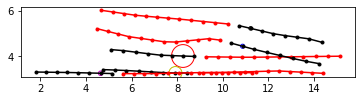

In [57]:
### expected output: ###
### Visualization on trajectories and attention ###

visualize_dataloader(dloader_train, attn_scale=0.5, device=device)